In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [19]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [20]:
# Save references to each table
ST = Base.classes.station
ME = Base.classes.measurement

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(ME.date).order_by(ME.date.desc()).first()
most_recent_date

('2017-08-23',)

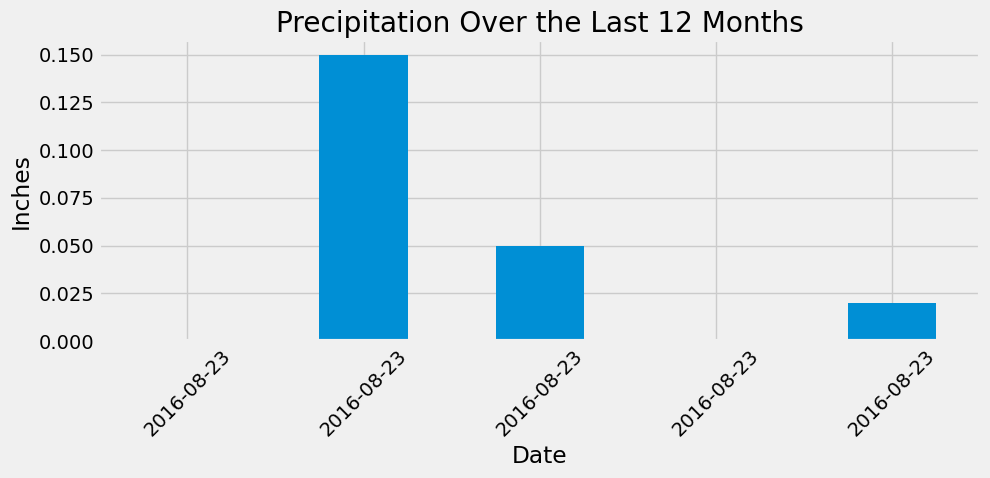

In [32]:
# Calculate the date one year from the last date in the data set
query_date = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
date_precipitation = session.query(ME.date, ME.prcp).\
    filter(ME.date >= query_date).\
    order_by(ME.date).all()

# Save the query results as a Pandas DataFrame
dp_df = pd.DataFrame(date_precipitation, columns=['date', 'prcp'])

# Sort the DataFrame by date
dp_df = dp_df.sort_values(by='date')

# Select only the first 5 rows of the DataFrame for plotting
dp_df_head = dp_df.head()

# Set the date as the index for plotting
dp_df_head.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
dp_df_head['prcp'].plot(kind='bar')  # Use dp_df_head here
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [35]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stat = dp_df['prcp'].describe()
precipitation_stat

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [36]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(ST).count()
station_count

9

In [40]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(ME.station,
    func.count(ME.id).label('count')
).group_by(ME.station).\
    order_by(func.count(ME.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [43]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

# Query to calculate lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(ME.tobs).label('min_temp'),
    func.max(ME.tobs).label('max_temp'),
    func.avg(ME.tobs).label('avg_temp')
).filter(ME.station == most_active_station).all()

# Print the results
min_temp, max_temp, avg_temp = temperature_stats[0]
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

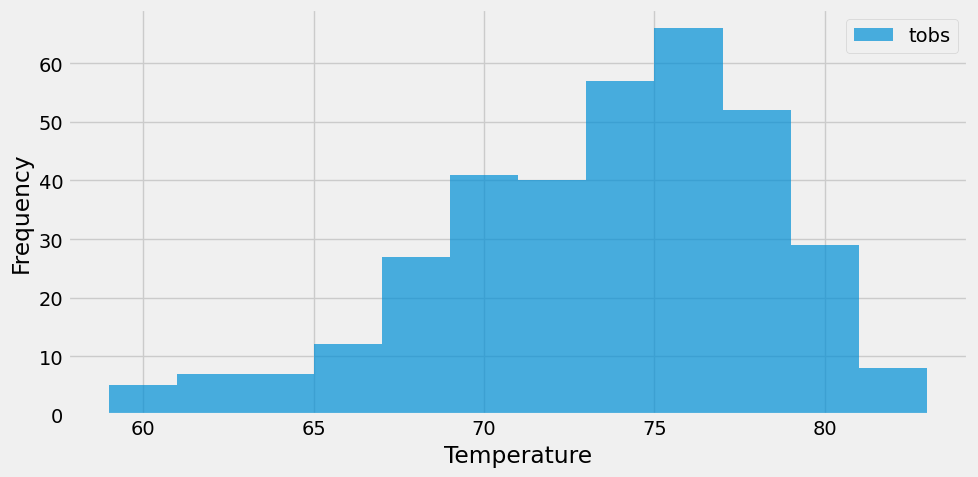

In [50]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Get the most active station from the previous query
most_active_station_id = 'USC00519281'  

# Calculate the date one year from the most recent date in the dataset
most_recent_date_station = session.query(ME.date).order_by(ME.date.desc()).first()[0]

# Convert the most_recent_date_station to a datetime object
most_recent_date_station = dt.datetime.strptime(most_recent_date_station, '%Y-%m-%d')

# Calculate the date one year from the most recent date in the dataset
query_date_station = most_recent_date_station - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data
temperature_data = session.query(ME.tobs).\
    filter(ME.station == most_active_station_id).\
    filter(ME.date >= query_date_station).\
    order_by(ME.date).all()

# Convert the results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Plot the results as a histogram
plt.figure(figsize=(10, 5))
temperature_df['tobs'].plot(kind='hist', bins=12, alpha=0.7, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.legend()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()